Data Loading

In [ ]:
from DecisionTree import DecisionTree
from CrossValidator import KFoldCrossValidator
from TreeEvaluator import TreeEvaluator
import numpy as np

## Loading datasets
clean_data = np.loadtxt('wifi_db/clean_dataset.txt')
noisy_data = np.loadtxt('wifi_db/noisy_dataset.txt')

## Last column is the label, which we should convert to int
clean_labels = clean_data[:, -1].astype(int)
noisy_labels = noisy_data[:, -1].astype(int)

clean_data = np.column_stack((clean_data[:, :-1], clean_labels))
noisy_data = np.column_stack((noisy_data[:, :-1], noisy_labels))

## check shape, we expect these to be the same
print(f"Clean data shape: {clean_data.shape}")
print(f"Noisy data shape: {noisy_data.shape}")

print(f"First row of clean data: {clean_data[0]}")
print(f"First row of noisy data: {noisy_data[0]}")

Clean data shape: (2000, 8)
Noisy data shape: (2000, 8)
First row of clean data: [-64. -56. -61. -66. -71. -82. -81.   1.]
First row of noisy data: [-59. -53. -51. -54. -45. -79. -87.   4.]
[[-64. -56. -61. ... -82. -81.   1.]
 [-68. -57. -61. ... -85. -85.   1.]
 [-63. -60. -60. ... -85. -84.   1.]
 ...
 [-62. -59. -46. ... -87. -88.   4.]
 [-62. -58. -52. ... -90. -85.   4.]
 [-59. -50. -45. ... -88. -87.   4.]]


Quick test to check that the trees are being created correctly

In [7]:
## We expect the tree to achieve 100% accuracy on the provided training data
tree = DecisionTree(clean_data)
tree.train(max_depth=None) # No max depth, fully grow the tree
avg_acc = TreeEvaluator.evaluate(clean_data, tree)
assert avg_acc == 1.0, f"Expected 100% accuracy on clean training data but got {avg_acc}"
print(f"Tree achieved 100% accuracy on training data.\nTree depth on clean data: {tree.depth}")

Tree achieved 100% accuracy on training data.
Tree depth on clean data: 14


Visualise the Tree (Up to depth 5)

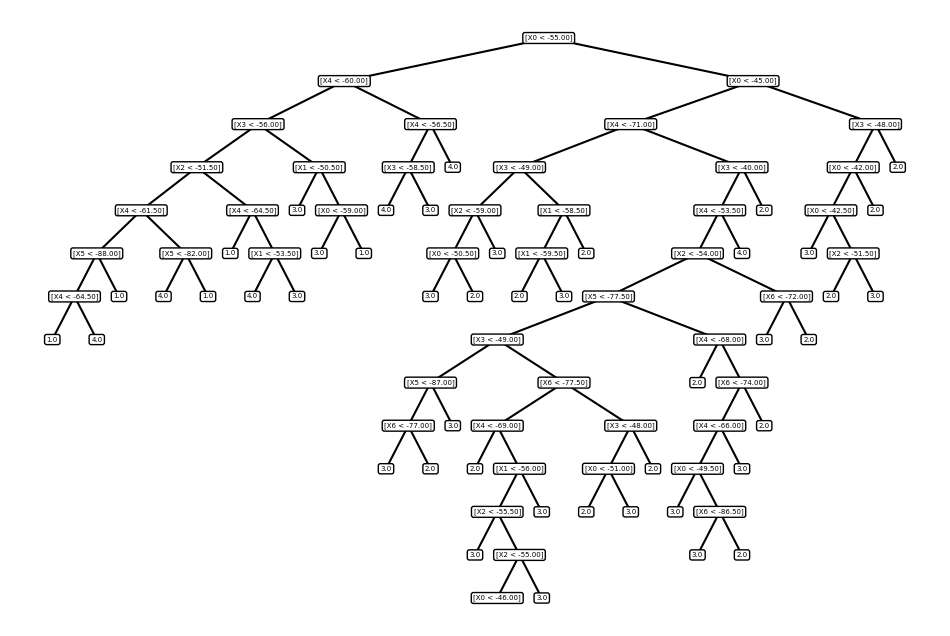

In [8]:
plt = tree.visualise(1, tree.depth)
plt.show()

10 Fold Cross Validation

In [9]:
tenFoldValidator = KFoldCrossValidator(DecisionTree, 10)

def process_metrics(metrics):
    # calculate precision, recall, f1 from confusion matrix
    confusion_matrix = metrics["avg_confusion_matrix"]
    label_to_index = metrics["label_to_index"]
    precision_dict, recall_dict= TreeEvaluator.get_precision_recall_per_class(
        confusion_matrix, label_to_index)
    per_label_f1 = {}
    for label in label_to_index.keys():
        f1 = TreeEvaluator.get_f1_score(precision_dict[label], recall_dict[label])
        per_label_f1[label] = f1
    metrics["precision"] = precision_dict
    metrics["recall"] = recall_dict
    metrics["f1_score"] = per_label_f1

## We expect the accuracies here to be different each time due to randomness in fold splitting
print("Performing 10-Fold Cross Validation on clean data:")
clean_metrics = tenFoldValidator.k_fold_cross_validation(clean_data)
process_metrics(clean_metrics)
print(clean_metrics)

# Python's maximum recursion depth is usually 1000
# The tree could sometimes exceed this depth on noisy data, leading to a RecursionError
# So we set a max depth of 1000 for noisy data
print("\nPerforming 10-Fold Cross Validation on noisy data:")
noisy_metrics = tenFoldValidator.k_fold_cross_validation(noisy_data, tree_depth=1000)
process_metrics(noisy_metrics)
print(noisy_metrics)

Performing 10-Fold Cross Validation on clean data:
Fold 1: Accuracy = 0.9750
Fold 2: Accuracy = 0.9800
Fold 3: Accuracy = 0.9750
Fold 4: Accuracy = 0.9700
Fold 5: Accuracy = 0.9600
Fold 6: Accuracy = 0.9750
Fold 7: Accuracy = 0.9800
Fold 8: Accuracy = 0.9800
Fold 9: Accuracy = 0.9600
Fold 10: Accuracy = 0.9700
{'average_accuracy': np.float64(0.9724999999999999), 'best_tree': <DecisionTree.DecisionTree object at 0x1115bef30>, 'avg_confusion_matrix': array([[48.8,  0. ,  0.2,  1. ],
       [ 0. , 48. ,  2. ,  0. ],
       [ 0.2,  1.4, 48.2,  0.2],
       [ 0.4,  0. ,  0.1, 49.5]]), 'label_to_index': {np.float64(1.0): 0, np.float64(2.0): 1, np.float64(3.0): 2, np.float64(4.0): 3}, 'precision': {np.float64(1.0): np.float64(0.9878542510121457), np.float64(2.0): np.float64(0.9716599190283401), np.float64(3.0): np.float64(0.9544554455445544), np.float64(4.0): np.float64(0.9763313609467456)}, 'recall': {np.float64(1.0): np.float64(0.976), np.float64(2.0): np.float64(0.96), np.float64(3.0): np.